## Incorporating Attention-Based GNNs and Graph Transformers with GNNExplainer for Graph Classification in Soccer Counterattack Analysis


### 1. Installing the required Python libraries:

In [1]:
# from google.colab import drive

# # Mount Google Drive
# drive.mount('/content/drive')

In [2]:
# !pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.1+cu118.html

In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GCNConv, global_mean_pool
import networkx as nx
from torch_geometric.utils import to_networkx
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import pickle
import requests
from os.path import isfile
import logging
import progressbar
import sys
from ipywidgets import Checkbox, Dropdown, Accordion, VBox
import ipywidgets as widgets
from IPython.display import display, clear_output
import copy
import pickle
import pandas as pd
import random
import time
# Setting up the logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)
stdout_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stdout_handler)

### 2. Data Processing

- `get_data()` fetches the specified file (Women, Men, Combined) from a public s3 bucket. The data is stored locally in {women, men, combined}.pkl. It is automatically loaded after downloading.
- Alternatively, the data can be downloaded into propoer directory and loaded from there.

In [4]:
def get_data(file_name):
    '''
    Fetches the file from the location, loads it into memory and returns the data.
    '''
    if not isfile(file_name):
        url = f"https://ussf-ssac-23-soccer-gnn.s3.us-east-2.amazonaws.com/public/counterattack/{file_name}"

        logger.info(f"Downloading data from {url}...")

        r = requests.get(url, stream=True)
        # Fancy code to print progress bar
        block_size = 1024
        n_chunk = 1000
        file_size = int(r.headers.get('Content-Length', None))
        num_bars = np.ceil(file_size / (n_chunk * block_size))
        bar =  progressbar.ProgressBar(maxval=num_bars).start()
        with open(file_name, 'wb') as f:
            for i, chunk in enumerate(r.iter_content(chunk_size=n_chunk * block_size)):
                f.write(chunk)
                bar.update(i+1)
                # Add a little sleep so you can see the bar progress
                time.sleep(0.05)

        logger.info("File downloaded successfully!")

    logger.info(f"Opening {file_name}...")
    with open(file_name, 'rb') as handle:
        data = pickle.load(handle)
    return data

### 2.1 Choose Dataset Type

Choose the type of file for training the GNN. Options available are women's data (which include women's data from the 2022 NWSL and International women's soccer between 2020 and 2022), men's data (data from the 2022 MLS) and a combined data file (includes both women's and men's data).

In [5]:
print("Choose File for training:")
file_widget = Dropdown(
    options=['Women', 'Men', 'Combined'],
    value='Women',
    disabled=False,
)
display(file_widget)

Choose File for training:


Dropdown(options=('Women', 'Men', 'Combined'), value='Women')

### 2.2 (Down)load Data
Using the file selection widget we load the appropriate file from s3.

In [6]:
# file_name = file_widget.value.lower() + '.pkl'
# # Obtain the data
# og_data = get_data(file_name)

Opening women.pkl...


INFO:__main__:Opening women.pkl...


Using the file selection widget we load the appropriate file locally.

In [10]:
file_name = 'datasets/' + file_widget.value.lower() + '.pkl'
logger.info(f"Opening {file_name}...")
with open(file_name, 'rb') as handle:
    og_data = pickle.load(handle)

Opening datasets/women.pkl...


### 2.3 Update dataset with selected features
The loaded dataset is updated to include only the selected node features and edge features

In [11]:
# Define checkboxes for edge features
player_dist = widgets.Checkbox(value=True, description='Player Distance', disabled=False)
speed_diff_matrix = widgets.Checkbox(value=True, description='Speed Difference', disabled=False)
pos_sin_angle = widgets.Checkbox(value=True, description='Positional Sine angle', disabled=False)
pos_cos_angle = widgets.Checkbox(value=True, description='Positional Cosine angle', disabled=False)
vel_sin_angle = widgets.Checkbox(value=True, description='Velocity Sine angle', disabled=False)
vel_cos_angle = widgets.Checkbox(value=True, description='Velocity Cosine angle', disabled=False)

# Define checkboxes for node features
x_coord = widgets.Checkbox(value=True, description='x coordinate', disabled=False)
y_coord = widgets.Checkbox(value=True, description='y coordinate', disabled=False)
vx = widgets.Checkbox(value=True, description='vX', disabled=False)
vy = widgets.Checkbox(value=True, description='vY', disabled=False)
v = widgets.Checkbox(value=True, description='Velocity', disabled=False)
velocity_angle = widgets.Checkbox(value=True, description='Velocity Angle', disabled=False)
dist_goal = widgets.Checkbox(value=True, description='Distance to Goal', disabled=False)
goal_angle = widgets.Checkbox(value=True, description='Angle with Goal', disabled=False)
dist_ball = widgets.Checkbox(value=True, description='Distance to Ball', disabled=False)
ball_angle = widgets.Checkbox(value=True, description='Angle with Ball', disabled=False)
is_attacking = widgets.Checkbox(value=True, description='Attacking Team Flag', disabled=False)
potential_receiver = widgets.Checkbox(value=True, description='Potential Receiver', disabled=False)

# Group edge and node features into VBox widgets
edge_f_box = widgets.VBox([player_dist, speed_diff_matrix, pos_sin_angle, pos_cos_angle, vel_sin_angle, vel_cos_angle])
node_f_box = widgets.VBox([x_coord, y_coord, vx, vy, v, velocity_angle, dist_goal, goal_angle, dist_ball, ball_angle, is_attacking, potential_receiver])

# Create an accordion to toggle between edge and node features
accordion = widgets.Accordion(children=[edge_f_box, node_f_box])
accordion.set_title(0, 'Edge Features')
accordion.set_title(1, 'Node Features')

# Display the accordion
display(accordion)

Accordion(children=(VBox(children=(Checkbox(value=True, description='Player Distance'), Checkbox(value=True, d…

In [12]:
def filter_features(data, adj_matrix='normal'):
    """
    Filter the node and edge features based on user selections.
    """
    # Extract user selections for edge features
    edge_feature_idxs = [idx for idx, cb in enumerate(edge_f_box.children) if cb.value]
    node_feature_idxs = [idx for idx, cb in enumerate(node_f_box.children) if cb.value]

    # Check for valid feature selection
    if not edge_feature_idxs and not node_feature_idxs:
        print("\nCannot have zero edge and zero node features.\n")
        return data

    # Filter node and edge features in the data
    data[adj_matrix]['e'] = [x[:, edge_feature_idxs] for x in data[adj_matrix]['e']]
    data[adj_matrix]['x'] = [x[:, node_feature_idxs] for x in data[adj_matrix]['x']]

    return data

# Apply feature filtering
filtered_data = filter_features(og_data.copy())

In [13]:
def process_data(data, adj_matrix='normal'):
    """
    Converts the filtered dataset to PyTorch Geometric format.
    """
    data_mat = data[adj_matrix]
    graph_list = []

    for x, a, e, y in zip(data_mat['x'], data_mat['a'], data_mat['e'], data['binary']):
        # Convert sparse matrix to COO format (edge_index)
        a_coo = a.tocoo()  # Convert sparse matrix to COO format

        # Convert edge indices to numpy array and then to tensor
        edge_index = np.vstack([a_coo.row, a_coo.col])
        edge_index = torch.tensor(edge_index, dtype=torch.long)

        # Create PyG Data object
        graph_data = Data(
            x=torch.tensor(x, dtype=torch.float),
            edge_index=edge_index,
            edge_attr=torch.tensor(e, dtype=torch.float),
            y=torch.tensor(y, dtype=torch.float).view(1, -1)
        )
        graph_list.append(graph_data)

    return graph_list

# Convert to PyG dataset
data_list = process_data(filtered_data)

# Display the number of graphs processed
print(f"Number of graphs processed: {len(data_list)}")

Number of graphs processed: 4348


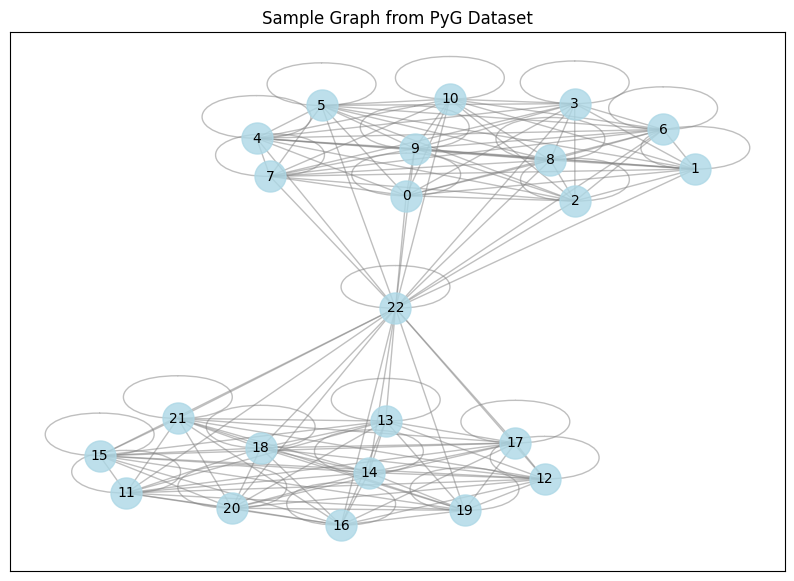

In [14]:
def visualize_graph_simple(data, node_color='lightblue', edge_color='gray'):
    """
    Visualize a single graph from the PyG dataset without showing vectors.
    """
    # Convert PyG data to a NetworkX graph
    G = to_networkx(data, to_undirected=True)

    # Set up node labels as simple indices
    node_labels = {i: i for i in range(data.num_nodes)}

    # Plotting
    plt.figure(figsize=(10, 7))
    pos = nx.spring_layout(G)  # Spring layout for better visualization

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=500, alpha=0.8)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color=edge_color, alpha=0.5)

    # Draw node labels
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

    plt.title("Sample Graph from PyG Dataset")
    plt.show()

# Select a sample graph from the preprocessed dataset
sample_graph = data_list[0]

# Visualize the selected sample graph
visualize_graph_simple(sample_graph)


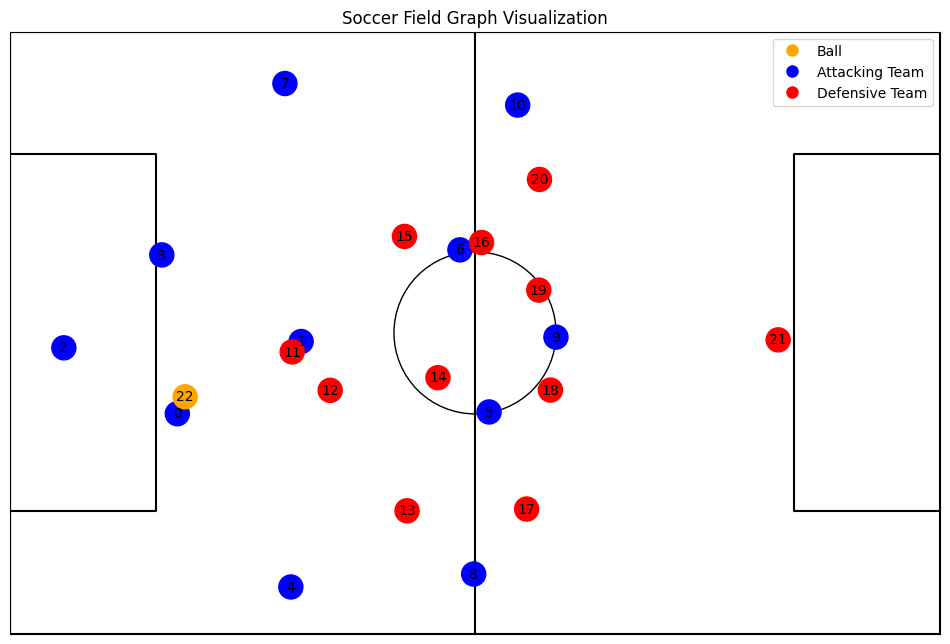

In [15]:
def draw_soccer_field(ax=None):
    """
    Draws a 2D soccer field on a Matplotlib axis.
    """
    if ax is None:
        ax = plt.gca()

    # Soccer field dimensions (in meters)
    field_length = 105
    field_width = 68

    # Outline & center line
    ax.plot([0, 0, field_length, field_length, 0], [0, field_width, field_width, 0, 0], color="black")
    ax.plot([field_length / 2, field_length / 2], [0, field_width], color="black")

    # Center circle
    center_circle = plt.Circle((field_length / 2, field_width / 2), 9.15, color="black", fill=False)
    ax.add_artist(center_circle)

    # Penalty area (left & right)
    penalty_area_width = 40.3
    penalty_area_length = 16.5
    ax.plot([0, penalty_area_length, penalty_area_length, 0],
            [(field_width - penalty_area_width) / 2, (field_width - penalty_area_width) / 2,
             (field_width + penalty_area_width) / 2, (field_width + penalty_area_width) / 2],
            color="black")
    ax.plot([field_length, field_length - penalty_area_length, field_length - penalty_area_length, field_length],
            [(field_width - penalty_area_width) / 2, (field_width - penalty_area_width) / 2,
             (field_width + penalty_area_width) / 2, (field_width + penalty_area_width) / 2],
            color="black")

    # Set field limits and aspect ratio
    ax.set_xlim(0, field_length)
    ax.set_ylim(0, field_width)
    ax.set_aspect('equal')

def identify_teams_and_ball(data):
    """
    Identifies the ball and teams based on the attacking team flag.
    - Ball: The node with the highest degree.
    - Team 1: Nodes with Attacking Team Flag = 1 (attacking team).
    - Team 2: Nodes with Attacking Team Flag = 0 (defensive team).
    """
    # Convert PyG data to a NetworkX graph
    G = to_networkx(data, to_undirected=True)

    # Find the node with the highest degree (ball node)
    degrees = dict(G.degree())
    ball_node = max(degrees, key=degrees.get)

    # Team 1 and Team 2 based on Attacking Team Flag
    team1_nodes = [i for i in range(data.num_nodes) if data.x[i][-2].item() == 1]  # Attacking team
    team2_nodes = [i for i in range(data.num_nodes) if data.x[i][-2].item() == 0]  # Defensive team

    return G, ball_node, team1_nodes, team2_nodes

def visualize_soccer_graph(data):
    """
    Visualizes the soccer graph on a 2D soccer field with a legend.
    - Identifies the ball and teams based on the attacking team flag.
    """
    # Identify the ball and teams based on the flag
    G, ball_node, team1_nodes, team2_nodes = identify_teams_and_ball(data)

    # Extract node positions from node features and scale to field dimensions
    field_length = 105
    field_width = 68
    node_positions = {i: (data.x[i][0].item() * field_length, data.x[i][1].item() * field_width)
                      for i in range(data.num_nodes)}

    # Define colors for ball, attacking team, and defensive team
    node_colors = []
    for i in range(data.num_nodes):
        if i == ball_node:
            node_colors.append('orange')  # Ball color
        elif i in team1_nodes:
            node_colors.append('blue')  # Attacking team color
        else:
            node_colors.append('red')  # Defensive team color

    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # Draw the soccer field
    draw_soccer_field(ax)

    # Draw nodes (players/ball)
    nx.draw_networkx_nodes(G, node_positions, node_color=node_colors, node_size=300, ax=ax)

    # # Draw edges within teams and between team members and the ball
    # for u, v in G.edges():
    #     if (u == ball_node or v == ball_node) or (u in team1_nodes and v in team1_nodes) or (u in team2_nodes and v in team2_nodes):
    #         nx.draw_networkx_edges(G, node_positions, edgelist=[(u, v)], edge_color='gray', ax=ax)

    # Add labels for node indices
    nx.draw_networkx_labels(G, node_positions, ax=ax, font_size=10, font_color='black')

    # Add legend
    legend_labels = {'orange': 'Ball', 'blue': 'Attacking Team', 'red': 'Defensive Team'}
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=legend_labels[color],
                                 markerfacecolor=color, markersize=10) for color in legend_labels]
    ax.legend(handles=legend_handles, loc='upper right')

    plt.title("Soccer Field Graph Visualization")
    plt.show()

# Visualize a sample graph from the dataset on a soccer field
visualize_soccer_graph(data_list[0])

* Edge Features:
  * Player Distance - Distance between two players connected to each other
  * Speed Difference - Speed difference between two players connected to each other
  * Positional Sine angle - Sine of the angle created between two players in the edge
  * Positional Cosine angle - Cosine of the angle created between two players in the edge
  * Velocity Sine angle - Sine of the angle created between the velocity vectors of two players in the edge
  * Velocity Cosine angle - Coine of the angle created between the velocity vectors of two players in the edge
      
* Node Features:
  * x coordinate - x coordinate on the 2D pitch for the player / ball
  * y coordinate - y coordinate on the 2D pitch for the player / ball
  * vx - Velocity vector's x coordinate
  * vy - Velocity vector's y coordinate
  * Velocity - magnitude of the velocity
  *  Velocity Angle - angle made by the velocity vector
  * Distance to Goal - distance of the player from the goal post
  * Angle with Goal - angle made by the player with the goal
  * Distance to Ball - distance from the ball (always 0 for the ball)
  * Angle with Ball - angle made with the ball (always 0 for the ball)
  * Attacking Team Flag - 1 if the team is attacking, 0 if not and for the ball
  * Potential Receiver - 1 if player is a potential receiver, 0 otherwise

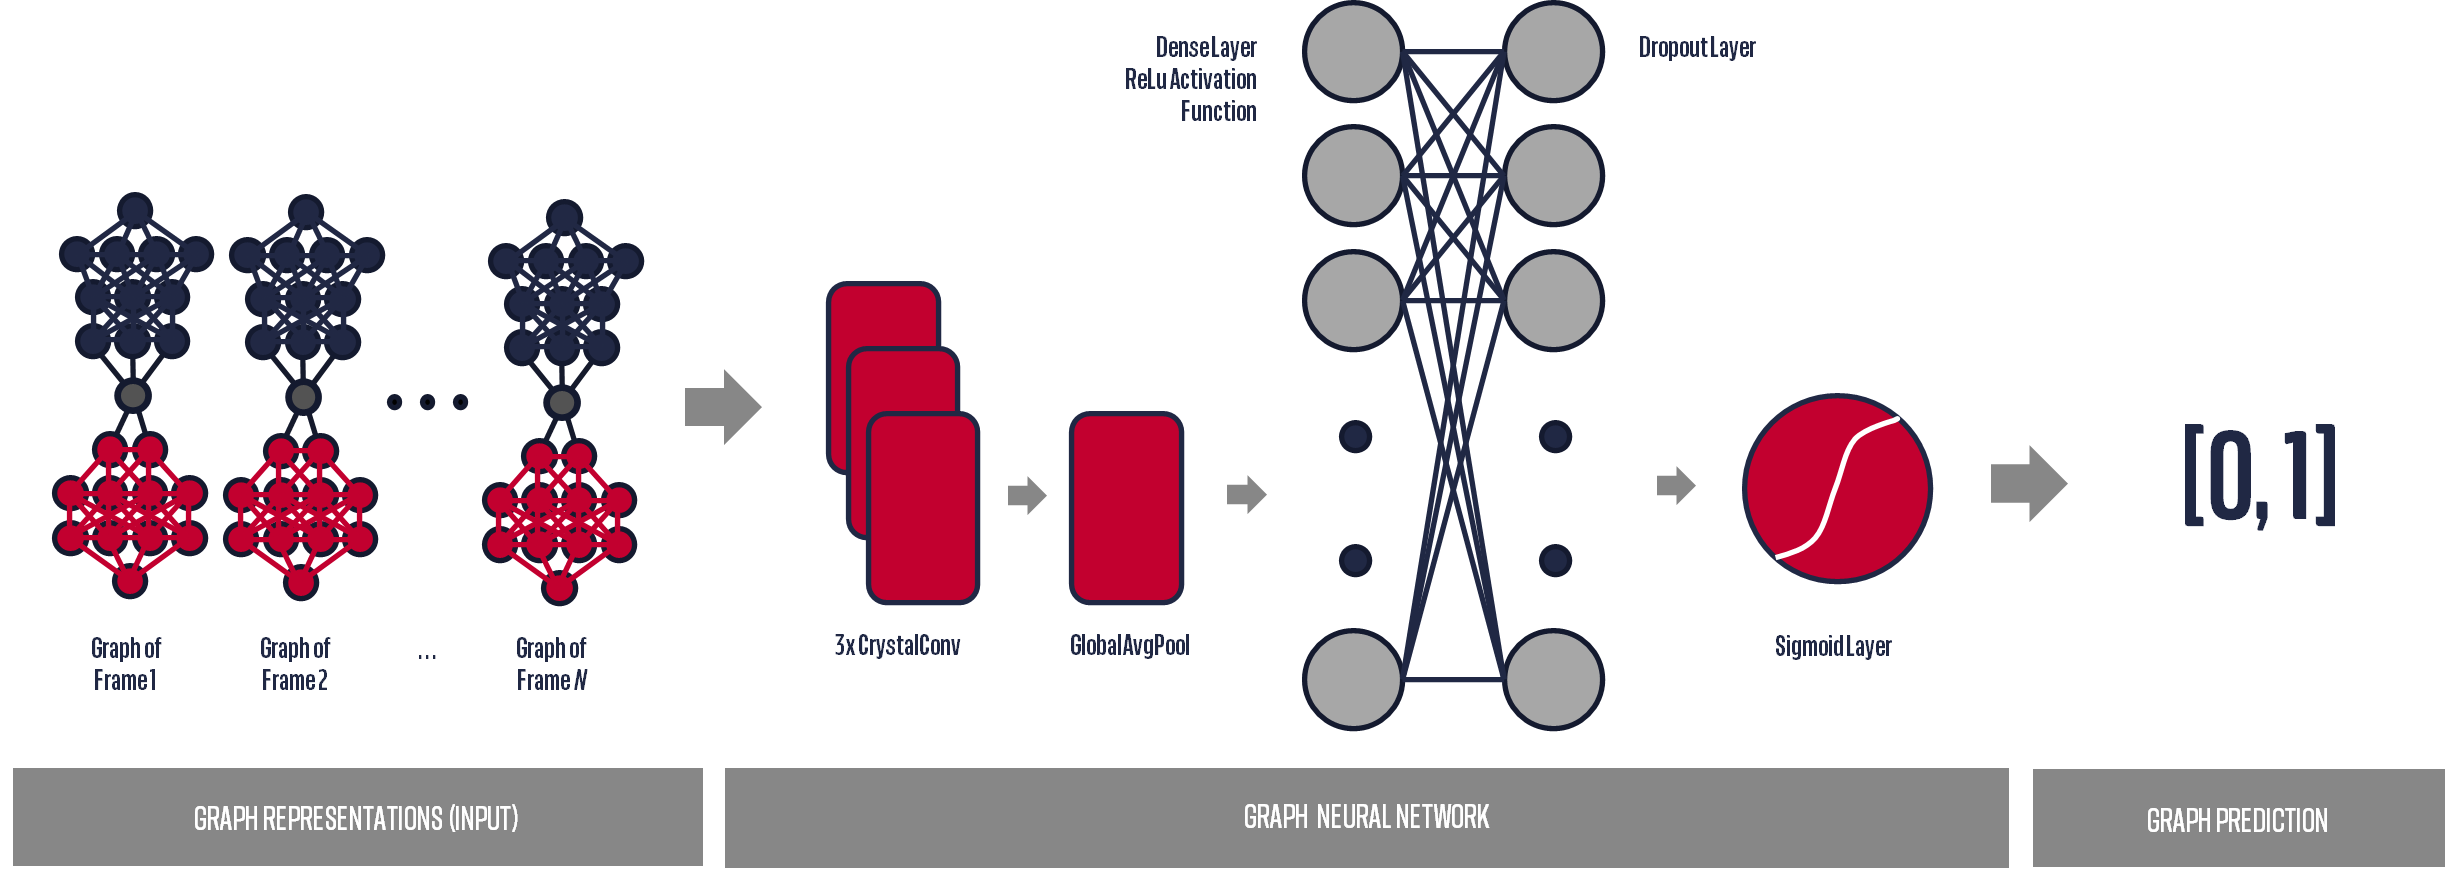

Epoch: 010, Train Loss: 0.6259, Val Loss: 0.6400, Val AUC: 0.6806, Val Acc: 0.6318, Val Prec: 0.6632, Val Rec: 0.5740, Val F1: 0.6154


INFO:__main__:Epoch: 010, Train Loss: 0.6259, Val Loss: 0.6400, Val AUC: 0.6806, Val Acc: 0.6318, Val Prec: 0.6632, Val Rec: 0.5740, Val F1: 0.6154


Epoch: 020, Train Loss: 0.6075, Val Loss: 0.6373, Val AUC: 0.6844, Val Acc: 0.6260, Val Prec: 0.7023, Val Rec: 0.4709, Val F1: 0.5638


INFO:__main__:Epoch: 020, Train Loss: 0.6075, Val Loss: 0.6373, Val AUC: 0.6844, Val Acc: 0.6260, Val Prec: 0.7023, Val Rec: 0.4709, Val F1: 0.5638


Epoch: 030, Train Loss: 0.5890, Val Loss: 0.6353, Val AUC: 0.6901, Val Acc: 0.6318, Val Prec: 0.6886, Val Rec: 0.5157, Val F1: 0.5897


INFO:__main__:Epoch: 030, Train Loss: 0.5890, Val Loss: 0.6353, Val AUC: 0.6901, Val Acc: 0.6318, Val Prec: 0.6886, Val Rec: 0.5157, Val F1: 0.5897


Epoch: 040, Train Loss: 0.5680, Val Loss: 0.6573, Val AUC: 0.6819, Val Acc: 0.6237, Val Prec: 0.6545, Val Rec: 0.5650, Val F1: 0.6065


INFO:__main__:Epoch: 040, Train Loss: 0.5680, Val Loss: 0.6573, Val AUC: 0.6819, Val Acc: 0.6237, Val Prec: 0.6545, Val Rec: 0.5650, Val F1: 0.6065


Epoch: 050, Train Loss: 0.5543, Val Loss: 0.6622, Val AUC: 0.6806, Val Acc: 0.6352, Val Prec: 0.6757, Val Rec: 0.5561, Val F1: 0.6101


INFO:__main__:Epoch: 050, Train Loss: 0.5543, Val Loss: 0.6622, Val AUC: 0.6806, Val Acc: 0.6352, Val Prec: 0.6757, Val Rec: 0.5561, Val F1: 0.6101


Epoch: 060, Train Loss: 0.5120, Val Loss: 0.7133, Val AUC: 0.6663, Val Acc: 0.6087, Val Prec: 0.6152, Val Rec: 0.6345, Val F1: 0.6247


INFO:__main__:Epoch: 060, Train Loss: 0.5120, Val Loss: 0.7133, Val AUC: 0.6663, Val Acc: 0.6087, Val Prec: 0.6152, Val Rec: 0.6345, Val F1: 0.6247


Epoch: 070, Train Loss: 0.4814, Val Loss: 0.7345, Val AUC: 0.6490, Val Acc: 0.6087, Val Prec: 0.6305, Val Rec: 0.5740, Val F1: 0.6009


INFO:__main__:Epoch: 070, Train Loss: 0.4814, Val Loss: 0.7345, Val AUC: 0.6490, Val Acc: 0.6087, Val Prec: 0.6305, Val Rec: 0.5740, Val F1: 0.6009


Epoch: 080, Train Loss: 0.4442, Val Loss: 0.7496, Val AUC: 0.6524, Val Acc: 0.6157, Val Prec: 0.6223, Val Rec: 0.6390, Val F1: 0.6305


INFO:__main__:Epoch: 080, Train Loss: 0.4442, Val Loss: 0.7496, Val AUC: 0.6524, Val Acc: 0.6157, Val Prec: 0.6223, Val Rec: 0.6390, Val F1: 0.6305


Epoch: 090, Train Loss: 0.4337, Val Loss: 0.8295, Val AUC: 0.6513, Val Acc: 0.6007, Val Prec: 0.6176, Val Rec: 0.5830, Val F1: 0.5998


INFO:__main__:Epoch: 090, Train Loss: 0.4337, Val Loss: 0.8295, Val AUC: 0.6513, Val Acc: 0.6007, Val Prec: 0.6176, Val Rec: 0.5830, Val F1: 0.5998


Epoch: 100, Train Loss: 0.3893, Val Loss: 0.8710, Val AUC: 0.6564, Val Acc: 0.6087, Val Prec: 0.6100, Val Rec: 0.6592, Val F1: 0.6336


INFO:__main__:Epoch: 100, Train Loss: 0.3893, Val Loss: 0.8710, Val AUC: 0.6564, Val Acc: 0.6087, Val Prec: 0.6100, Val Rec: 0.6592, Val F1: 0.6336


Epoch: 110, Train Loss: 0.3798, Val Loss: 0.8777, Val AUC: 0.6698, Val Acc: 0.6133, Val Prec: 0.6196, Val Rec: 0.6390, Val F1: 0.6291


INFO:__main__:Epoch: 110, Train Loss: 0.3798, Val Loss: 0.8777, Val AUC: 0.6698, Val Acc: 0.6133, Val Prec: 0.6196, Val Rec: 0.6390, Val F1: 0.6291


Epoch: 120, Train Loss: 0.3440, Val Loss: 1.0206, Val AUC: 0.6769, Val Acc: 0.6237, Val Prec: 0.6434, Val Rec: 0.5987, Val F1: 0.6202


INFO:__main__:Epoch: 120, Train Loss: 0.3440, Val Loss: 1.0206, Val AUC: 0.6769, Val Acc: 0.6237, Val Prec: 0.6434, Val Rec: 0.5987, Val F1: 0.6202


Epoch: 130, Train Loss: 0.3246, Val Loss: 1.0880, Val AUC: 0.6688, Val Acc: 0.6145, Val Prec: 0.6188, Val Rec: 0.6480, Val F1: 0.6331


INFO:__main__:Epoch: 130, Train Loss: 0.3246, Val Loss: 1.0880, Val AUC: 0.6688, Val Acc: 0.6145, Val Prec: 0.6188, Val Rec: 0.6480, Val F1: 0.6331


Epoch: 140, Train Loss: 0.3122, Val Loss: 1.2020, Val AUC: 0.6765, Val Acc: 0.6157, Val Prec: 0.6233, Val Rec: 0.6345, Val F1: 0.6289


INFO:__main__:Epoch: 140, Train Loss: 0.3122, Val Loss: 1.2020, Val AUC: 0.6765, Val Acc: 0.6157, Val Prec: 0.6233, Val Rec: 0.6345, Val F1: 0.6289


Epoch: 150, Train Loss: 0.2731, Val Loss: 1.1729, Val AUC: 0.6551, Val Acc: 0.5972, Val Prec: 0.6106, Val Rec: 0.5942, Val F1: 0.6023


INFO:__main__:Epoch: 150, Train Loss: 0.2731, Val Loss: 1.1729, Val AUC: 0.6551, Val Acc: 0.5972, Val Prec: 0.6106, Val Rec: 0.5942, Val F1: 0.6023


Test Loss: 1.1872, Test AUC: 0.6573, Test Acc: 0.6170, Test Prec: 0.6305, Test Rec: 0.6767, Test F1: 0.6528


INFO:__main__:Test Loss: 1.1872, Test AUC: 0.6573, Test Acc: 0.6170, Test Prec: 0.6305, Test Rec: 0.6767, Test F1: 0.6528


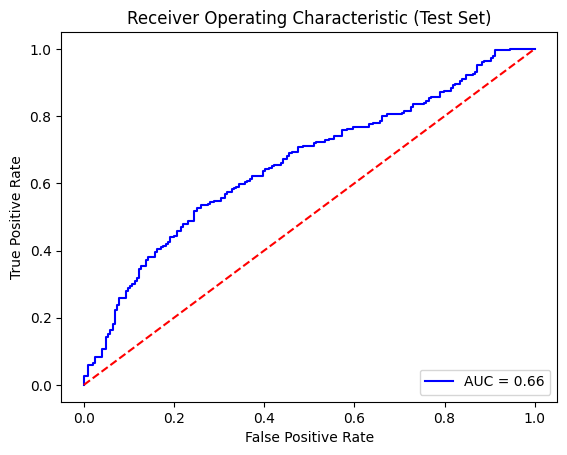

In [9]:
# Hyperparameters
learning_rate = 1e-3  # Learning rate
epochs = 150  # Number of training epochs
batch_size = 16  # Batch size
channels = 128  # Hidden units for the neural network
layers = 3  # Number of GCN layers

# Train/validation/test split
train_size = int(0.7 * len(data_list))
val_size = int(0.2 * len(data_list))
test_size = len(data_list) - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(data_list, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=layers):
        super(GNN, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.dropout = torch.nn.Dropout(0.5)
        self.lin1 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
        x = global_mean_pool(x, batch)
        x = self.dropout(x)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

# Model, optimizer, and loss function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(in_channels=data_list[0].num_node_features,
            hidden_channels=channels,
            out_channels=1,
            num_layers=layers).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCEWithLogitsLoss()

def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()

        # Forward pass
        out = model(batch.x, batch.edge_index, batch.batch)

        # Align target shape with the output
        loss = criterion(out.squeeze(), batch.y.view(-1))

        # Backward pass
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs

    return total_loss / len(train_loader.dataset)

def compute_metrics(y_true, y_pred, threshold=0.5):
    """
    Compute evaluation metrics based on predictions.
    """
    y_pred_label = (y_pred >= threshold).astype(int)

    accuracy = accuracy_score(y_true, y_pred_label)
    precision = precision_score(y_true, y_pred_label)
    recall = recall_score(y_true, y_pred_label)
    f1 = f1_score(y_true, y_pred_label)

    return accuracy, precision, recall, f1

def evaluate(loader, threshold=0.5):
    model.eval()
    y_true = []
    y_pred = []
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out.squeeze(), batch.y.view(-1))
            total_loss += loss.item() * batch.num_graphs

            y_true.append(batch.y.cpu().numpy())
            y_pred.append(out.sigmoid().cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)
    auc_score = roc_auc_score(y_true, y_pred)

    # Compute additional metrics
    accuracy, precision, recall, f1 = compute_metrics(y_true, y_pred, threshold)

    return total_loss / len(loader.dataset), auc_score, accuracy, precision, recall, f1, y_true, y_pred

# Training loop with validation
for epoch in range(1, epochs + 1):
    train_loss = train()

    if epoch % 10 == 0:
        val_loss, val_auc, val_accuracy, val_precision, val_recall, val_f1, _, _ = evaluate(val_loader)
        logger.info(
            f"Epoch: {epoch:03d}, "
            f"Train Loss: {train_loss:.4f}, "
            f"Val Loss: {val_loss:.4f}, "
            f"Val AUC: {val_auc:.4f}, "
            f"Val Acc: {val_accuracy:.4f}, "
            f"Val Prec: {val_precision:.4f}, "
            f"Val Rec: {val_recall:.4f}, "
            f"Val F1: {val_f1:.4f}"
        )

# Final evaluation on the test set
test_loss, test_auc, test_accuracy, test_precision, test_recall, test_f1, y_true, y_pred = evaluate(test_loader)
fpr, tpr, _ = roc_curve(y_true, y_pred)

# Print test results
logger.info(
    f"Test Loss: {test_loss:.4f}, "
    f"Test AUC: {test_auc:.4f}, "
    f"Test Acc: {test_accuracy:.4f}, "
    f"Test Prec: {test_precision:.4f}, "
    f"Test Rec: {test_recall:.4f}, "
    f"Test F1: {test_f1:.4f}"
)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='b', label=f'AUC = {test_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Test Set)')
plt.legend(loc='lower right')
plt.show()